In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [2]:
import os
os.environ['PYTHONHASHSEED']= '100'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(100)
python_random.seed(100)
tf.random.set_seed(100)

In [3]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import yfinance as yf
stock_symbol = '1155.KL'

# 3 years data
#dataset_train = yf.download(tickers=stock_symbol,start="2019-06-20", end="2022-06-20",interval='1d')

# 1 year data
#dataset_train = yf.download(tickers=stock_symbol,start="2021-06-20", end="2022-06-20",interval='1d')

# 5 year data
dataset_train = yf.download(tickers=stock_symbol,start="2017-06-20", end="2022-06-20",interval='1d')


#dataset_train = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [5]:
dataset_train.drop(dataset_train.tail(1).index,inplace=True)

In [6]:
dataset_train.reset_index(level=0, inplace=True)

In [7]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1230 non-null   datetime64[ns]
 1   Open       1230 non-null   float64       
 2   High       1230 non-null   float64       
 3   Low        1230 non-null   float64       
 4   Close      1230 non-null   float64       
 5   Adj Close  1230 non-null   float64       
 6   Volume     1230 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 67.4 KB


In [8]:
dataset_train['Date'] = dataset_train['Date'].astype(str)


In [9]:
dataset_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-20,9.63,9.65,9.62,9.64,6.708943,24095000
1,2017-06-21,9.62,9.64,9.55,9.59,6.674145,17090300
2,2017-06-22,9.56,9.60,9.51,9.58,6.667186,7971500
3,2017-06-23,9.58,9.60,9.58,9.60,6.681105,9432400
4,2017-06-26,9.60,9.60,9.60,9.60,6.681105,0
...,...,...,...,...,...,...,...
1225,2022-06-10,8.80,8.81,8.75,8.75,8.750000,5540600
1226,2022-06-13,8.71,8.72,8.60,8.68,8.680000,9847100
1227,2022-06-14,8.64,8.72,8.61,8.68,8.680000,12044600
1228,2022-06-15,8.68,8.69,8.60,8.63,8.630000,6405300


In [10]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:7]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]


In [11]:
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (1230, 7)
All timestamps == 1230
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [12]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

In [13]:
# Using multiple features (predictors)
training_set = dataset_train.values

training_set

array([[9.63000011e+00, 9.64999962e+00, 9.61999989e+00, 9.64000034e+00,
        6.70894289e+00, 2.40950000e+07],
       [9.61999989e+00, 9.64000034e+00, 9.55000019e+00, 9.59000015e+00,
        6.67414522e+00, 1.70903000e+07],
       [9.56000042e+00, 9.60000038e+00, 9.51000023e+00, 9.57999992e+00,
        6.66718626e+00, 7.97150000e+06],
       ...,
       [8.64000034e+00, 8.72000027e+00, 8.60999966e+00, 8.68000031e+00,
        8.68000031e+00, 1.20446000e+07],
       [8.68000031e+00, 8.68999958e+00, 8.60000038e+00, 8.63000011e+00,
        8.63000011e+00, 6.40530000e+06],
       [8.67000008e+00, 8.72000027e+00, 8.65999985e+00, 8.72000027e+00,
        8.72000027e+00, 5.46460000e+06]])

In [14]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[ 0.99994165],
       [ 0.98798314],
       [ 0.91623439],
       ...,
       [-0.18392304],
       [-0.13609016],
       [-0.14804867]])

In [15]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 7   # Number of days we want top predict into the future
n_past = 30     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1194, 30, 5).
y_train shape == (1194, 1).


In [16]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [17]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=64, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.20))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer ='adam', loss='mean_squared_error',metrics=['RootMeanSquaredError'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           68608     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [18]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=64)

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 0.2217 - root_mean_squared_error: 0.4708
Epoch 1: val_loss improved from inf to 0.05304, saving model to weights.h5
15/15 [==============================] - 6s 158ms/step - loss: 0.2217 - root_mean_squared_error: 0.4708 - val_loss: 0.0530 - val_root_mean_squared_error: 0.2303 - lr: 0.0010
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.1270 - root_mean_squared_error: 0.3564
Epoch 2: val_loss improved from 0.05304 to 0.03466, saving model to weights.h5
15/15 [==============================] - 2s 164ms/step - loss: 0.1270 - root_mean_squared_error: 0.3564 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1862 - lr: 0.0010
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.1076 - root_mean_squared_error: 0.3280
Epoch 3: val_loss did not improve from 0.03466
15/15 [==============================] - 2s 163ms/step - loss: 0.1076 - root_mean_squared_error: 0.3280 - val_loss: 0.0420 -

In [19]:

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [20]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [21]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2017-09-21,9.585172
2017-09-22,9.629742
2017-09-25,9.671372


In [22]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-01-01'

In [23]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

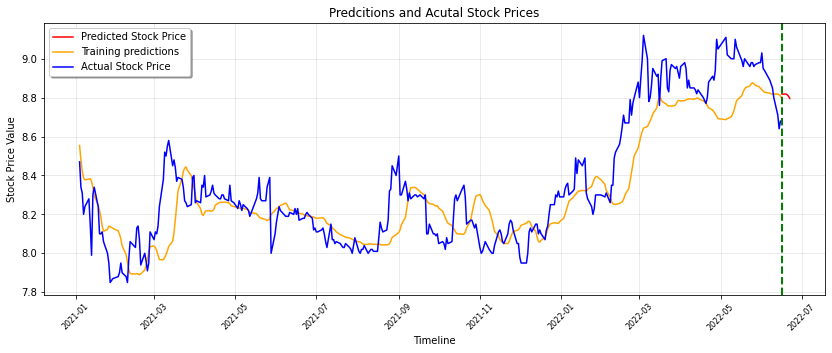

In [24]:
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', fontsize=12)
plt.xlabel('Timeline', fontsize=10)
plt.ylabel('Stock Price Value', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [25]:
from matplotlib import pyplot
from numpy import array

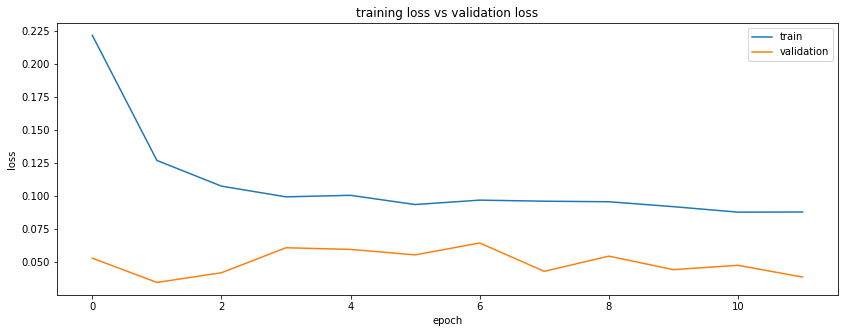

In [26]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('training loss vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [27]:
print(history.history['loss'])
print(history.history['val_loss'])

[0.22168448567390442, 0.1270068883895874, 0.10755444318056107, 0.0994570255279541, 0.10060443729162216, 0.09362826496362686, 0.09696577489376068, 0.09615781903266907, 0.09573829919099808, 0.09202086925506592, 0.0878659337759018, 0.0879887118935585]
[0.053035277873277664, 0.03466012701392174, 0.04200174659490585, 0.060926176607608795, 0.05966247245669365, 0.05552414804697037, 0.0645345076918602, 0.04306359216570854, 0.054565779864788055, 0.044347379356622696, 0.04763170704245567, 0.03874420002102852]


In [28]:
print(history.history['root_mean_squared_error'])
print(history.history['val_root_mean_squared_error'])

[0.47083380818367004, 0.35638025403022766, 0.3279549479484558, 0.31536808609962463, 0.3171820342540741, 0.3059873580932617, 0.31139329075813293, 0.3100932538509369, 0.3094160556793213, 0.30334940552711487, 0.2964218854904175, 0.2966289222240448]
[0.2302938997745514, 0.18617230653762817, 0.20494326949119568, 0.24683228135108948, 0.2442590296268463, 0.23563562333583832, 0.25403642654418945, 0.20751769840717316, 0.2335931956768036, 0.21058817207813263, 0.21824689209461212, 0.196835458278656]
